# Homework Assignment 4: Feature Selection
As in the previous assignments, in this homework assignment you will continue your exploration of the [SWAN-SF Dataset](https://doi.org/10.7910/DVN/EBCFKM), described in the paper found [here](https://doi.org/10.1038/s41597-020-0548-x).


This assignment will utilize a copy of the feature dataset we have been working with, but has had some additional preprocessing like clipping, z-score normalization, and range normalization performed on it. 

## Downloading the Data

This assignment will continue to only use [Partition 1](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB). Recall that in Homework 1, we started to construct the analytics base table (abt) for our [SWAN-SF Dataset](https://doi.org/10.7910/DVN/EBCFKM). In that assignment, we read the data from the two subdirectories, __FL__ and __NF__, of the __partition1__ direcotry. These two subdirectories represented the two classes of our target feature in the solar flare prediction problem we will be attempting to solve this semester. We then processed these samples of multivariate time series to construct descriptive features for each sample, and then placed them into our analytics base table.

Then, in Homework 2, you utilized a set of extracted descriptive features much like what you were asked to construct in Homework 1. However, this dataset contained many more extracted features than you were asked to compute for Homework 1 (>800), so we needed to explore the data to find data quality issues and identify ways to address these issues. Below are the links to the full extracted feature for all of partition 1, and a toy representative dataset, that were used as input to Homework 2.

- [Full Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/partition1ExtractedFeatures.csv)
- [Toy Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_partition1ExtractedFeatures.csv)

Then, in Homework 3, you were asked to perform additional data preprocessing on data that would have been produced from Homework 2. The links to those files are below.  

- [Full Cleaned Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/cleaned_partition1ExtractedFeatures.csv)
- [Toy Cleaned Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_cleaned_partition1ExtractedFeatures.csv)
- [Data Quality Table for Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/data_quality_table.csv)

The preprocessing you were asked to do in Homework 3 included finding features with large ranges and features with a large number of outliers. You were asked to clip some of the outliers for the features you found and were also asked to perform a few different types of scaling, such as decimal and z-score.  I have done much more of this preprocessing for you, and have constructed a set of files for you to use for this assignment.  

Below you will find the full normalized and a toy normalized data file.  Some of the questions I've asked of you this week do take some time for the processing to complete. So, if you find yourself running out of time for them to complete processing, I suggest you switch to using the toy data. Your results don't need to be based on the full data (though that is preferable), your code just needs to do what is asked regardless of the file used as input.

- [Full Normalized Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/normalized_partition1ExtractedFeatures.csv)  `<-- For this assignment`
- [Toy Normalized Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_normalized_partition1ExtractedFeatures.csv) `<-- For this assignment`

Now that you have the normalized features csv files, you will load that data into a Pandas DataFrame using the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method. 

In [1]:
%matplotlib inline
import os
import pandas as pd
from pandas import DataFrame 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn import metrics

In [2]:
data_dir = ''                                   # TODO: update the path
data_file = 'normalized_partition1ExtractedFeatures.csv'
#data_file = 'toy_normalized_partition1ExtractedFeatures.csv'

In [3]:
%%time

abt = pd.read_csv(os.path.join(data_dir, data_file))

Wall time: 9.54 s


Before we try any feature selection technique, let's try the classifier that you recently learned. Note that since the focus of this assignment is not on classification, we restrict ourselves to a very simple approach. This simplisity may not reflect good practices of training and testing models, but gives us what we want for now. We will worry about those concerns in the next assignment.

Below, a helper function is implemented that takes a dataframe (e.g. our `abt`) and prepares it for a binary classification by merging the `X`- and `M`-class samples into one group, and the rest (`NF`, `B`, and `C`) into another group, labeled with `1`s and `0`s, respectively.

In [4]:
def dichotomize_X_y(data: pd.DataFrame):
    """
    dichotomizes the dataset and split it into the features (X) and the labels (y).
    
    :return: two np.ndarray objects X and y.
    """
    data_dich = data.copy()
    data_dich['lab'] = data_dich['lab'].map({'NF': 0, 'B': 0, 'C': 0, 'M': 1, 'X': 1})
    y = data_dich['lab'].copy()
    X = data_dich.copy().drop(['lab'], axis=1)
    return X.values, y.values

____
Your work starts from here.

### Q1. Classification of Flaring and Non-Flaring Samples (15 points)

The goal is to run a simple classifier, i.e., *$k$-Nearest Neighbor*, on the `abt` dataset with all of its 639 features. In the snippet below, we (1) dichotomize the data, (2) split the data into 3 strata, (3) run `kNN` on each split, and (4) measure its performance using $f_1$ score.

I have already done the parts 1 and 2. Your job is to carry out 3 and 4: within each iteration, fit the `kNN` classifier (using [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) on a subset of the data, and based on the predicted labels and the ground-truth labels, compute [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). At the end, you should report the average $f_1$ score, across all 3 splits.

If you are curious about `StratifiedKFold`, you can read about it [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold). In short, it gives us subsets of data, which "contains approximately the same percentage of samples of each target class." This is a variation of $k$-fold cross-validation technique that is generally used to ensure that models' performance is not simply the result of a lucky (or unlucky) sampling.

In [5]:
%%time
X, y = dichotomize_X_y(abt)
skf = StratifiedKFold(n_splits=3)
comb1 = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #----------------------------------------------
    neigh = kNN(n_neighbors = 3)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    comb1 += metrics.f1_score(y_test, pred)
    #----------------------------------------------
avg = comb1 / 3
avg

Wall time: 1min 10s


0.9599768211609817

**Note:** In ML courses, you often see very high model performance which is not so easy to achieve in real-world problems. SWAN-SF indeed presents a real-world problem. But your average $f_1$ score might still be very high (e.g., about 0.95), although we used a very simple classifier! Why do you think the reason is?

### Q2. Feature Selection: SelectKBest + ANOVA Test (15 points)

For your convenience, the data you are using for this homework assignment (`Full Normalized Partition 1 feature dataset`) is already cleaned up in such a way that none of the features contain any `NaN` or `Inf` values. Using the cleaned data, you now need to perform feature selection on the dataset and take the 5 most useful features for classification. To perform the ranking you will utilize the statistical test *ANOVA F-Value* to score the features and then you will need to select the top 5 features. Since ANOVA measures the impact of each feature's variance on the response variable (e.g., the class labels `NF`, `B`, `C`, `M`, `X`). Therefore, we will keep all 5 labels of the data. In other words, do not use the function `dichotomize_X_y`.

**Hint:** For feature selection use the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). The function [scikit-learn f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) should be used as the scoring function when initializing the class.

Once you have used the `SelectKBest` class to perform feature selection, you shuld construct a new `DataFrame` with the `lab` class labels, and the selected 5 features. In the next quesiton, you will plot them to compare, just like we did in the last assignment.

**Note:** Using the `fit_transform` function of the `SelectKBest` class gives you the slected features, but it does not give you the feature names. So, you should utilzie another function to get the names of the features and then manually construct a DataFrame yourself. 

In [6]:
%%time
#----------------------------------------------
a1 = abt['lab'].copy()
a2 = abt.copy().drop(['lab'], axis = 1)
a_y = SelectKBest(k=5)
nums = a_y.fit_transform(a2, a1)
n_index = a_y.get_support(indices = True)
cols = a2.columns[n_index]
q2 = abt[cols].copy()
q2 = q2.join(a1)
q2
#----------------------------------------------

Wall time: 918 ms


,TOTUSJH_quadratic_weighted_average,TOTUSJH_last_value,ABSNJZH_stddev,ABSNJZH_gderivative_stddev,SAVNCPP_gderivative_stddev,lab
0,0.537152,0.524792,0.299874,0.234357,0.144180,C
1,0.099692,0.128706,0.065623,0.066060,0.035237,NF
2,0.381901,0.389401,0.316796,0.191449,0.075663,C
3,0.133424,0.129889,0.089638,0.078581,0.027455,NF
4,0.228032,0.229568,0.109415,0.118807,0.044561,NF
...,...,...,...,...,...,...
73487,0.083995,0.081776,0.076687,0.082038,0.027026,NF
73488,0.112764,0.126202,0.086741,0.075052,0.021325,NF
73489,0.152113,0.163386,0.130103,0.125347,0.051220,NF
73490,0.067725,0.070062,0.055230,0.058843,0.017399,NF


### Q3. Visualization of the ANOVA Dim-reduced Space (5 points)

Since we cannot even imagine a 5-dimensional space, we won't be able to visualize the dimension-reduced space of our data. But we can do the next best thing which is looking at the 2-dimensional slices of that space.

For this question plot the features you obtained in Q2, using a Scatter Plot Matrix. To accomplish this, use the seaborn [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function. Make sure distinct colors as used to represent the classes. This should give you a matrix of 5X5 scatter plots, each with a pair of features as its axes.

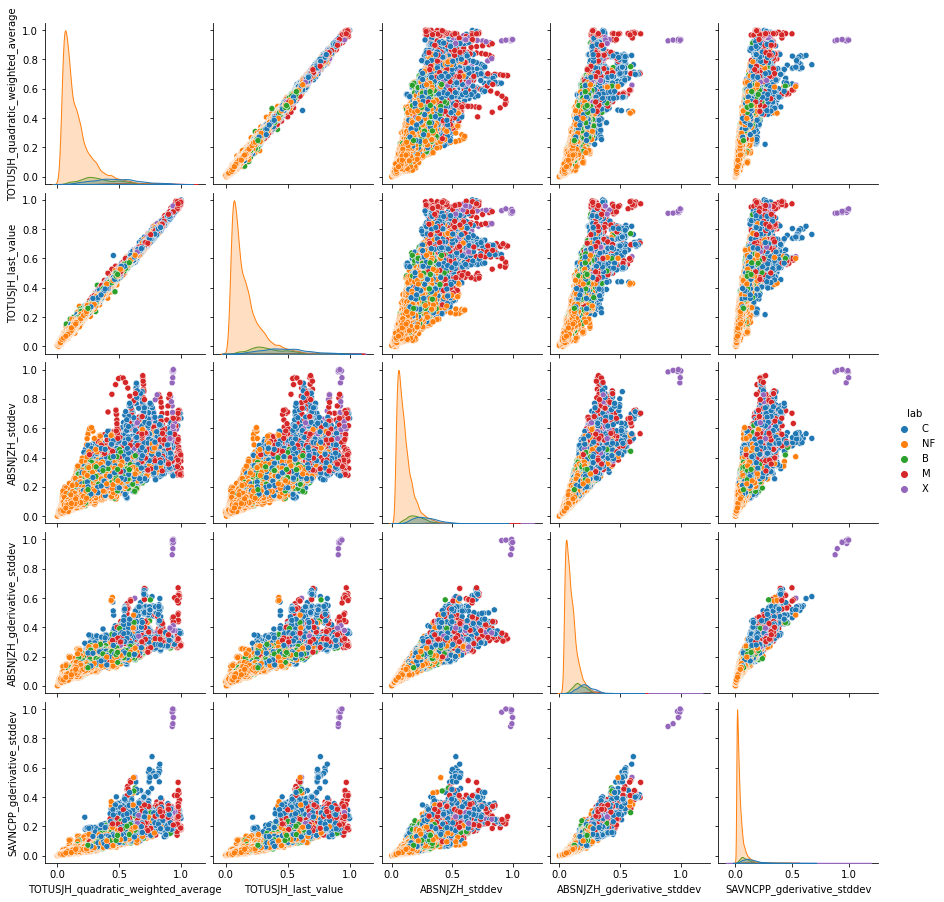

In [7]:
sns.pairplot(q2, hue='lab')

If your feature selection and cleaning above works correctly, you should see that several features were chosen that: 

* look to be highly correlated with one another, and
* show most (if not all) of the `X`-class flares as a distinct group apart from all of the other classes. 

This shows us that there are features that can be used to group many of the `X`-class flares into a (relatively) pure cluster, and also that many of these features are redundant. So, maybe we need to look into selecting features using another feature selection method. We will do this in Q5. But before that let's find another way of looking at the quality of the dimension-reduced space.

### Q4. Classification on the ANOVA Dim-reduced Space (10 points)

Using the ANOVA F-value, we managed to get rid of 634 features. It would be interesting to see how this huge dimensionality reduction impacts $k$-NN's performance. Following what you did for Q1, use the new dataset (that has only the 5 selected features and the labels) for a binary classification using $k$-NN.

If you compare the average $f_1$ score of this experiment with that of Q1, you may see a significant drop, but remember that we reduced the dimensionality from 639 to only 5 features.

In [8]:
%%time
X, y = dichotomize_X_y(q2)
skf = StratifiedKFold(n_splits=3)
comb4 = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #----------------------------------------------
    neigh = kNN(n_neighbors = 3)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    comb4 += metrics.f1_score(y_test, pred)
    #----------------------------------------------
avg = comb4 / 3
avg

Wall time: 2.6 s


0.5963042928257848

### Q5. Feature Selection: SelectKBest + Mutual Information (15 points)

Repeat the feature selection you did for Q2, but this time, instead of using the ANOVA F-Value to score the features, you will be utilizing *Mutual Information* (MI) to select the features.

**Hint:** Use the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). The function of [scikit-learn mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) should be used as the scoring function when initializing the class.

Just like you did in Q2, once you have used the `SelectKBest` class to perform feature selection, you shuld construct a new `DataFrame` with the `lab` class labels, and the selected 5 features.

In [9]:
%%time
#----------------------------------------------
a1 = abt['lab'].copy()
a2 = abt.copy().drop(['lab'], axis = 1)
a_y = SelectKBest(k=5, score_func = mutual_info_classif)
nums = a_y.fit_transform(a2, a1)
n_index = a_y.get_support(indices = True)
cols = a2.columns[n_index]
q5 = abt[cols].copy()
q5 = q5.join(a1)
q5
#----------------------------------------------

Wall time: 5min 59s


,TOTUSJH_slope_of_longest_mono_increase,ABSNJZH_slope_of_longest_mono_increase,MEANJZD_slope_of_longest_mono_increase,SAVNCPP_slope_of_longest_mono_increase,TOTFY_slope_of_longest_mono_decrease,lab
0,0.147257,0.142250,0.014992,0.079789,0.960412,C
1,0.113385,0.065779,0.117085,0.040001,0.989543,NF
2,0.152243,0.152104,0.058336,0.097718,0.972797,C
3,0.080197,0.061096,0.067792,0.017575,0.992623,NF
4,0.120329,0.095447,0.066791,0.037625,0.973228,NF
...,...,...,...,...,...,...
73487,0.060189,0.057378,0.137913,0.017946,0.998041,NF
73488,0.051077,0.056652,0.100839,0.019768,0.992015,NF
73489,0.089101,0.108752,0.136256,0.053945,0.962645,NF
73490,0.055532,0.035571,0.148354,0.011258,0.999439,NF


Did you notice that one of the 2 feature selection methods we tried took much longer? On my machine, ANOVA took only 798 ms while MI took 4min and 13s, i.e., over 300x longer!

### Q6. Visualization of the MI Dim-reduced Space (5 points)

Just like you did before, visualize the selected features using a Scatter Plot Matrix.

In this plot, you should see that several of the features selected by the the mutual information method work well to cluster the `NF` samples, but don't do quite as good of a job at clustering the `X`- and `M`-class samples. 

Like the features we found using ANOVA F-Value, and that we plotted in the last assignment, we still don't see any two as being able to correctly distinguish between all the different classes in our dataset. What differences do you notice?

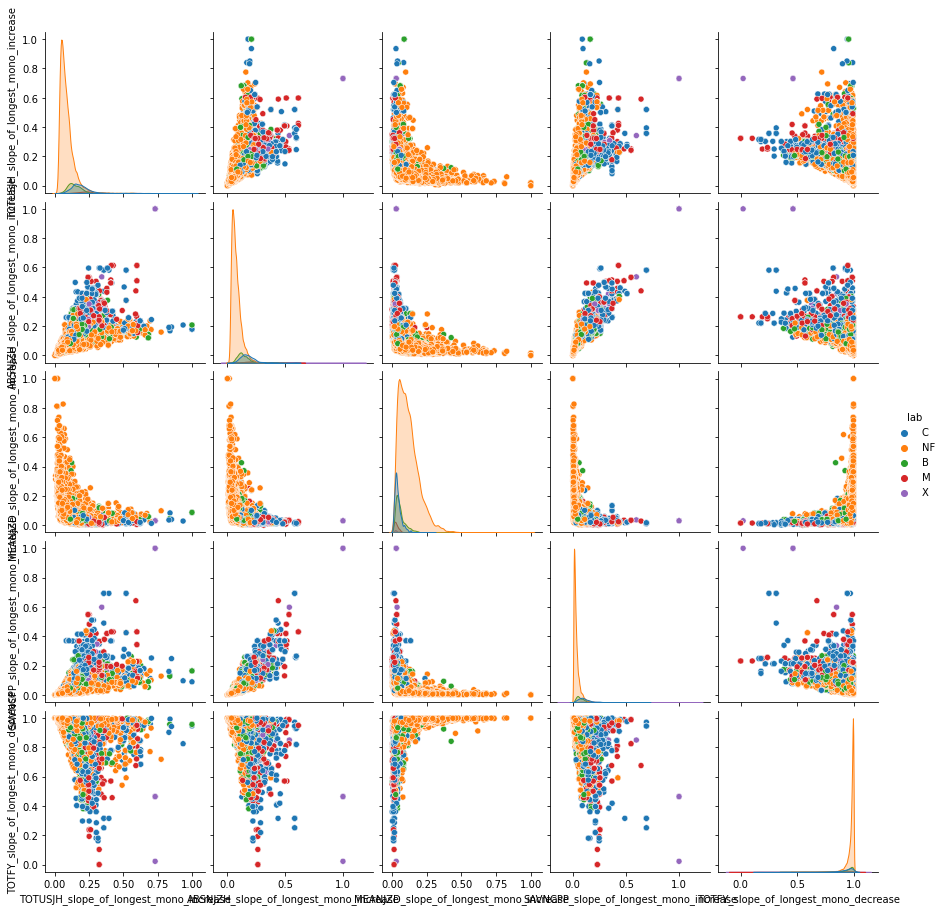

In [10]:
sns.pairplot(q5, hue='lab')

### Q7. Classification on the MI Dim-reduced Space (10 points)

Similar to Q4, we want to use $k$-NN to examine the impact of dimensionality reduction of `SelectKBest` using Mutual Information. 

How does this average $f_1$ score compares to those in Q1 and Q4?

In [11]:
%%time
a1, a2 = dichotomize_X_y(q2)
skf = StratifiedKFold(n_splits=3)
comb7 = 0
for train_index, test_index in skf.split(a1, a2):
    a1_train, a1_test = a1[train_index], a1[test_index]
    a2_train, a2_test = a2[train_index], a2[test_index]
    #----------------------------------------------
    neigh = kNN()
    neigh.fit(a1_train, a2_train)
    pred = neigh.predict(a1_test)
    comb7 += metrics.f1_score(a2_test, pred)
    #----------------------------------------------
avg = comb7 / 3
avg

Wall time: 2.57 s


0.5614338689645731

### Q8. Feature Selection Using Decision Tree (20 points)

There are a number of different feature selection techniques. But some classifiers have embedded feature selection methods which are used to find an optimal decision boundary for classification. Decision Tree is one of them. Since we have recently went through the idee behind it and how it works, it might be a good idea to try this one as well.

Use [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit your model on the original dataset (with all the features in it). Since we do not want to invest too much on the classifier, you should limit your tree's depth to 3. Similar to what you did for Q1, Q4, and Q7, use `StratifiedKFold` and predict the (binary) labels. Report the average $f_1$ score.

In addition, using the `feature_importances_` attribute of the `DecisionTreeClassifier`, you should be able to find out which features were picked at each trial. Find and print all *feature names* corresponding to importance scores greater than 0.0.

How does this average $f_1$ score compares with those in Q1, Q4, and Q7?

In [12]:
%%time
X, y = dichotomize_X_y(abt)
skf = StratifiedKFold(n_splits=3)
comb8 = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #----------------------------------------------
    neigh = tree.DecisionTreeClassifier(max_depth = 3);
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    comb8 += metrics.f1_score(y_test, pred)
    #----------------------------------------------
avg = comb8 / 3
avg

Wall time: 31.8 s


0.4393104522608772

### Q9. Compare Performances (5 points)

Plot the changes of $f_1$ score in questions Q1, Q4, Q7, and Q8, using seaborn's [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html). Recall that you have three $f_1$ scores per experiment from which you reported the average. A boxplot uses all those scores and shows the range of performance per experiment.

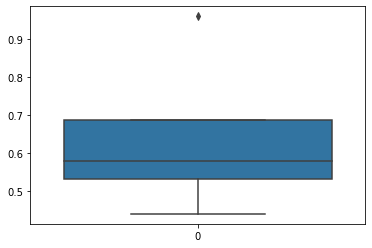

In [16]:
#----------------------------------------------
combs = [comb1/3, comb4/3, comb7/3, comb8/3]
bp = sns.boxplot(data=combs)
#----------------------------------------------

## End

Please use the `Kernel` menu to `Restart & Clear Output` prior to saving and submitting your assignment.